In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import h5py 
import datetime

# Root directory of the project
path = '/mnt/sh_flex_storage/malu/venv/CHIPS_MRCNN'
ROOT_DIR = os.path.abspath(path)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs_new")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [2]:
print('ROOT_DIR:',ROOT_DIR)
print('MODEL_DIR:',MODEL_DIR)
print('COCO_MODEL_PATH:',COCO_MODEL_PATH)

ROOT_DIR: /mnt/sh_flex_storage/malu/venv/CHIPS_MRCNN
MODEL_DIR: /mnt/sh_flex_storage/malu/venv/CHIPS_MRCNN/logs_new
COCO_MODEL_PATH: /mnt/sh_flex_storage/malu/venv/CHIPS_MRCNN/mask_rcnn_coco.h5


In [ ]:
train_path = 'new_train.h5'
test_path = 'new_test.h5'
train_set = h5py.File(train_path,'r')
test_set = h5py.File(test_path,'r')

train_images = train_set['input']
test_images = test_set['input']
train_masks = train_set['output']
test_masks = test_set['output']

del train_set
del test_set
NUM_TRAIN = train_images.shape[0] # 2224*224
NUM_TEST = test_images.shape[0]

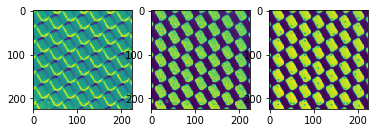

In [4]:
image_full = train_images[0,:].reshape((6,224,224))
image_sel = np.array([image_full[0,:,:],image_full[1,:,:],image_full[2,:,:]])
image_sel_reshape = np.zeros((224,224,3))
for i in range(224):
    for j in range(224):
        image_sel_reshape[i,j,:] = image_sel[:,i,j]      
for i in range(3):
    plt.subplot(1,3,i+1)
    img= image_sel[i,:,:]
    plt.imshow(img)
    plt.plot()


## Configurations

In [19]:
class ChipsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "chips"
    
    #CH
    BACKBONE = "resnet50"
    MINI_MASK_SHAPE = (28,28)
    DETECTION_MAX_INSTANCES = 100
    ROI_POSITIVE_RATIO = 0.16
    USE_MINI_MASK = True
    
    # TRY CH
    POOL_SIZE = 7
    MASK_POOL_SIZE = 14
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1 # CH
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)  # anchor side in pixels # CH

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 16 # CH 

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100
    
    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ChipsConfig()
config.display()

'''
not apply in network yet
ROI_POSITIVE_RATIO = 0.33 # before 0.16
STEPS_PER_EPOCH = 200
'''


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES 

'\nnot apply in network yet\nROI_POSITIVE_RATIO = 0.33 # before 0.16\nSTEPS_PER_EPOCH = 200\n'

## Notebook Preferences

In [32]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset


In [7]:
class ChipsDataset(utils.Dataset):
    def __init__(self, class_map=None):
        #new_append 
        self.num_null_mask = 0
        self.all_flaw_size = []
        self.subset = ""
        #original
        self._image_ids = []
        self.image_info = []
        # Background is always the first class
        self.class_info = [{"source": "", "id": 0, "name": "BG"}]
        self.source_class_ids = {}

    def load_chips(self, count,subset):
        assert subset in ["train","test"]
        
        self.subset = subset
        
        # Add classes
        self.add_class("chips", 1, "bump")
        self.add_class("chips", 2, "dent")
        self.add_class("chips", 3, "dot")

        # Add images
        # Images are generated on the fly in load_image().
        for i in range(count):
            chips = self.mask_prepare(i)
            self.add_image("chips", image_id=i, path=None,chips=chips)
            
    
    def mask_prepare(self,i,return_mask=False):
        if self.subset == "train":
            mask_full = train_masks[i,:].reshape((4,224,224))
        else :
            mask_full = test_masks[i,:].reshape((4,224,224))
        
        bump,dent,dot = mask_full[1,:,:],mask_full[2,:,:],mask_full[3,:,:]   
        flaw_size = [np.sum(bump),np.sum(dent),np.sum(dot)]
        names = ["bump","dent","dot"]

        if not np.sum(flaw_size):
            self.num_null_mask += 1
            #print("==== no flaw for image %d ===="%i)

        if not return_mask:
            chips= []
            for j in range(3):
                if flaw_size[j] >0:
                    chips.append(names[j])
                    self.all_flaw_size.append(flaw_size[j])
            return chips
        else:
            masks = []
            for j in range(3):
                if flaw_size[j] >0:
                    masks.append(mask_full[j+1,:,:])
            if not np.array(masks).shape[0]:
                return np.array(masks)
            else:
                masks = np.array(masks)
                masks = masks.reshape((-1,224,224))
                masks_reshape = np.zeros((224,224,masks.shape[0]))
                #assert masks.shape[1:] in [(224,224)]
                for i in range(224):
                    for j in range(224):
                        masks_reshape[i,j,:] = masks[:,i,j]  
                return masks_reshape
                      
        
    def load_image(self,image_id):
        info = self.image_info[image_id]
        
        #print("check load_image image_id: ",image_id)
        
        if self.subset == "train":
            image_full = train_images[image_id,:].reshape((6,224,224))
        else:
            image_full = test_images[image_id,:].reshape((6,224,224))
            
        image_sel = np.array([image_full[0,:,:],image_full[1,:,:],image_full[2,:,:]])
        image_sel_reshape = np.zeros((224,224,3))
        for i in range(224):
            for j in range(224):
                image_sel_reshape[i,j,:] = image_sel[:,i,j]  
        image = image_sel_reshape
        return image

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "chips":
            return info["chips"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        chips = info['chips']
        mask = self.mask_prepare(image_id,True)
        
        class_ids = np.array([self.class_names.index(s) for s in chips])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def info_display(self,count):
        #flaw_size info
        max_flaw_size = np.max(self.all_flaw_size)
        min_flaw_size = np.min(self.all_flaw_size)
        mean_flaw_size = np.mean(self.all_flaw_size)
        
        #flaw_kind_info
        bump_num,dent_num,dot_num = 0,0,0
        for i in range(count):
            chips = self.image_info[i]['chips']
            if "bump" in chips:
                bump_num +=1
            if "dent" in chips:
                dent_num +=1
            if "dot" in chips:
                dot_num += 1    
                
        #display all info
        print("**** info of %s dataset : ***  "%self.subset)
        print("  ratio of null mask images:%d %%"%(self.num_null_mask/count*100))
        print("  max flaw size:",max_flaw_size)
        print("  min flaw size:",min_flaw_size)
        print("  mean flaw size:",mean_flaw_size)
        print("  bump ratio:%d %%"%(bump_num/count*100))
        print("  dent ratio:%d %%"%(dent_num/count*100))
        print("  dot ratio:%d %%"%(dot_num/count*100))
        

In [8]:
# Testing dataset
dataset_test = ChipsDataset()
dataset_test.load_chips(NUM_TEST,"test")
dataset_test.prepare()
dataset_test.info_display(NUM_TEST)

**** info of test dataset : ***  
  ratio of null mask images:0 %
  max flaw size: 96
  min flaw size: 2
  mean flaw size: 29.385158254918736
  bump ratio:29 %
  dent ratio:41 %
  dot ratio:29 %


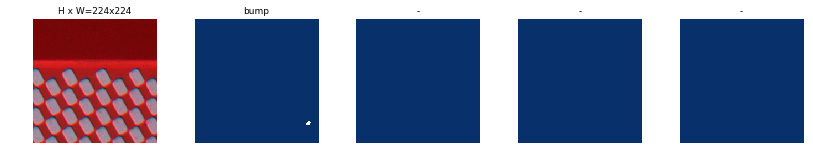

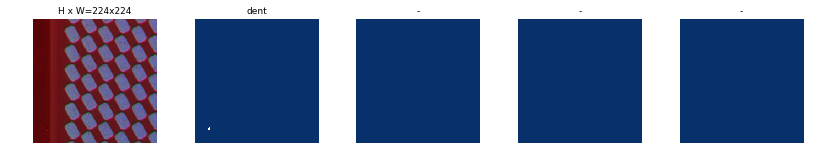

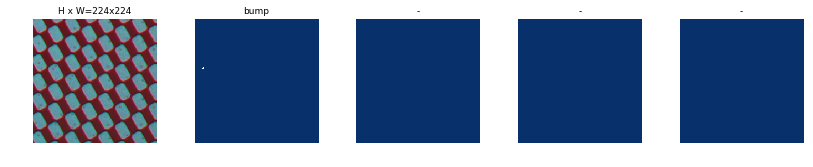

In [19]:
# Load and display random samples
image_ids = np.arange(3)
for image_id in image_ids:
    image = dataset_test.load_image(image_id)
    mask, class_ids = dataset_test.load_mask(image_id)
    if len(class_ids)>0:
        visualize.display_top_masks(image, mask, class_ids, dataset_test.class_names)

In [9]:
#Traning dataset
#cost several mins 
dataset_train = ChipsDataset()
dataset_train.load_chips(NUM_TRAIN,"train")
dataset_train.prepare()
dataset_train.info_display(NUM_TRAIN)

**** info of train dataset : ***  
  ratio of null mask images:0 %
  max flaw size: 102
  min flaw size: 2
  mean flaw size: 29.65715769880092
  bump ratio:28 %
  dent ratio:42 %
  dot ratio:28 %


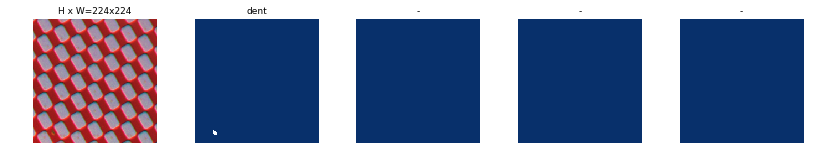

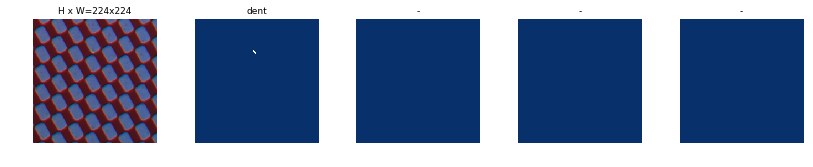

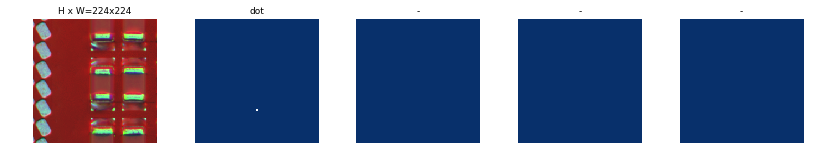

In [21]:
# Load and display random samples
image_ids = np.arange(3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    if len(class_ids)>0:
        visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [44]:
# Create model in training mode
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [45]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model_path = "/mnt/sh_flex_storage/malu/venv/CHIPS_MRCNN/logs_new/mask_rcnn_chips_0815.h5"
    # Load the last model you trained and continue training
    model.load_weights(model_path, by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [46]:
start = time.time()
# use_multiprocessing=False
model.train(dataset_train, dataset_test, 
            learning_rate=config.LEARNING_RATE, 
            epochs=100, 
            layers='heads')
print("time consuming:",time.time()-start)


Starting at epoch 0. LR=0.001

Checkpoint Path: /mnt/sh_flex_storage/malu/venv/CHIPS_MRCNN/logs_new/chips20180815T1637/mask_rcnn_chips_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Time

100/100 [==============================] - 91s 906ms/step - loss: 0.8653 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.2854 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.2179 - mrcnn_mask_loss: 0.3255 - val_loss: 0.8024 - val_rpn_class_loss: 0.0037 - val_rpn_bbox_loss: 0.2694 - val_mrcnn_class_loss: 0.0201 - val_mrcnn_bbox_loss: 0.1883 - val_mrcnn_mask_loss: 0.3208
Epoch 41/100
100/100 [==============================] - 89s 890ms/step - loss: 0.8681 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.2828 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.2253 - mrcnn_mask_loss: 0.3233 - val_loss: 0.8229 - val_rpn_class_loss: 0.0049 - val_rpn_bbox_loss: 0.2894 - val_mrcnn_class_loss: 0.0269 - val_mrcnn_bbox_loss: 0.1913 - val_mrcnn_mask_loss: 0.3103
Epoch 42/100
100/100 [==============================] - 88s 881ms/step - loss: 0.8354 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.2663 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.2186 - mrcnn_mask_loss: 0.3213 - val_loss: 0.8006 - val_rpn_class_lo

100/100 [==============================] - 87s 873ms/step - loss: 0.8326 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.2667 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.2105 - mrcnn_mask_loss: 0.3175 - val_loss: 0.8441 - val_rpn_class_loss: 0.0030 - val_rpn_bbox_loss: 0.2463 - val_mrcnn_class_loss: 0.0364 - val_mrcnn_bbox_loss: 0.2330 - val_mrcnn_mask_loss: 0.3254
Epoch 83/100
100/100 [==============================] - 89s 890ms/step - loss: 0.8601 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.2704 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.2248 - mrcnn_mask_loss: 0.3277 - val_loss: 0.7553 - val_rpn_class_loss: 0.0031 - val_rpn_bbox_loss: 0.2793 - val_mrcnn_class_loss: 0.0174 - val_mrcnn_bbox_loss: 0.1618 - val_mrcnn_mask_loss: 0.2938
Epoch 84/100
100/100 [==============================] - 89s 887ms/step - loss: 0.8471 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.2672 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.2197 - mrcnn_mask_loss: 0.3305 - val_loss: 0.8186 - val_rpn_class_lo

In [47]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_test, 
            learning_rate=config.LEARNING_RATE,
            epochs=200, 
            layers="all")


Starting at epoch 100. LR=0.001

Checkpoint Path: /mnt/sh_flex_storage/malu/venv/CHIPS_MRCNN/logs_new/chips20180815T1637/mask_rcnn_chips_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b   

Epoch 110/200
100/100 [==============================] - 85s 848ms/step - loss: 0.8677 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.2902 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.3243 - val_loss: 0.7860 - val_rpn_class_loss: 0.0055 - val_rpn_bbox_loss: 0.2509 - val_mrcnn_class_loss: 0.0350 - val_mrcnn_bbox_loss: 0.1828 - val_mrcnn_mask_loss: 0.3119
Epoch 111/200
100/100 [==============================] - 84s 839ms/step - loss: 0.8277 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.2715 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.3151 - val_loss: 0.7556 - val_rpn_class_loss: 0.0032 - val_rpn_bbox_loss: 0.2263 - val_mrcnn_class_loss: 0.0308 - val_mrcnn_bbox_loss: 0.1613 - val_mrcnn_mask_loss: 0.3339
Epoch 112/200
100/100 [==============================] - 85s 848ms/step - loss: 0.8185 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.2650 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.3191 - val_loss: 0.9140 - 

100/100 [==============================] - 85s 853ms/step - loss: 0.8045 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.2478 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.2021 - mrcnn_mask_loss: 0.3200 - val_loss: 0.5586 - val_rpn_class_loss: 0.0024 - val_rpn_bbox_loss: 0.1365 - val_mrcnn_class_loss: 0.0106 - val_mrcnn_bbox_loss: 0.1470 - val_mrcnn_mask_loss: 0.2621
Epoch 153/200
100/100 [==============================] - 84s 836ms/step - loss: 0.8082 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.2508 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.2120 - mrcnn_mask_loss: 0.3118 - val_loss: 0.6528 - val_rpn_class_loss: 0.0026 - val_rpn_bbox_loss: 0.1785 - val_mrcnn_class_loss: 0.0421 - val_mrcnn_bbox_loss: 0.1226 - val_mrcnn_mask_loss: 0.3070
Epoch 154/200
100/100 [==============================] - 84s 836ms/step - loss: 0.7862 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.2381 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.2065 - mrcnn_mask_loss: 0.3124 - val_loss: 0.7476 - val_rpn_class_

100/100 [==============================] - 84s 843ms/step - loss: 0.7009 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1995 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3010 - val_loss: 0.6138 - val_rpn_class_loss: 0.0034 - val_rpn_bbox_loss: 0.1416 - val_mrcnn_class_loss: 0.0160 - val_mrcnn_bbox_loss: 0.1605 - val_mrcnn_mask_loss: 0.2924
Epoch 195/200
100/100 [==============================] - 86s 863ms/step - loss: 0.6911 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1963 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.2992 - val_loss: 0.7096 - val_rpn_class_loss: 0.0026 - val_rpn_bbox_loss: 0.2036 - val_mrcnn_class_loss: 0.0277 - val_mrcnn_bbox_loss: 0.1822 - val_mrcnn_mask_loss: 0.2934
Epoch 196/200
100/100 [==============================] - 86s 859ms/step - loss: 0.6934 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.2017 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.1691 - mrcnn_mask_loss: 0.2932 - val_loss: 0.6777 - val_rpn_class_

In [48]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_chips_0815.h5")
model.keras_model.save_weights(model_path)

## Detection

In [49]:
class InferenceConfig(ChipsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir= MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
#model_path = os.path.join(MODEL_DIR, "mask_rcnn_chips.h5")
#model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /mnt/sh_flex_storage/malu/venv/CHIPS_MRCNN/logs_new/mask_rcnn_chips_0815.h5


In [1]:
14*225

3150

original_image           shape: (256, 256, 3)         min:   15.45313  max:  255.00000  float64
image_meta               shape: (16,)                 min:    0.00000  max: 1785.00000  float64
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:   31.00000  max:  253.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool


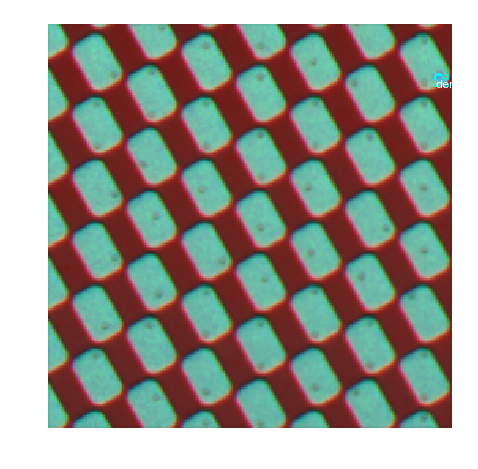

In [50]:
# Test on a random image
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8),colors=[(0.0, 1.0, 1.0)])

Processing 1 images
image                    shape: (256, 256, 3)         min:   15.45313  max:  255.00000  float64
molded_images            shape: (1, 256, 256, 3)      min: -108.24688  max:  131.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32


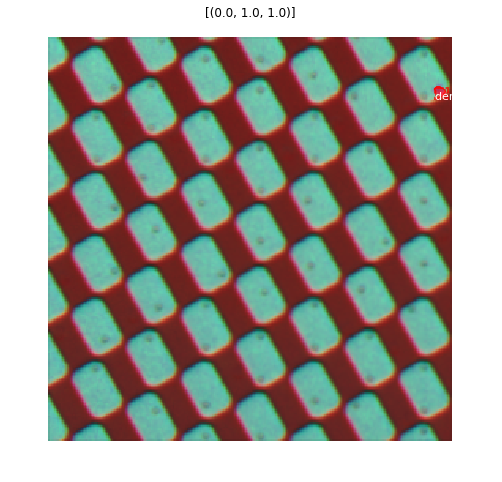

In [51]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], [(0.0, 1.0, 1.0)],ax=get_ax())

## Evaluation
- After 100 epoch :num_null_mask: 21 mAP:  0.5632911392405063
- After 200 epoch（head）,150 epoch(all):num_null_mask: 6 mAP:  0.9290780141843973

In [43]:
image_ids = np.random.choice(dataset_test.image_ids, 100)
APs = []
num_null_mask = 0

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]

    # Compute AP
    if r['masks'].shape[2]==0:
        num_null_mask += 1
        continue
    else:
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'],iou_threshold=0.3)
    APs.append(AP)

print("num_null_mask:",num_null_mask)
print("mAP: ", np.mean(APs))

num_null_mask: 7
mAP:  0.9336917562724014
